In [132]:
# R Jupyter Notebook for Data Engineering, Data Exploration and Basic Modelling
# Load some basic libraries
library(readr)
library(data.table)
library(ggplot2)
library(stringr)
library(lubridate)

In [133]:
# Read in the files from the directory
library(readr)
calendar_data <- read_csv("calendar.csv")
listings_data <- read_csv("listings.csv")
reviews_data <- read_csv("reviews.csv")

Parsed with column specification:
cols(
  listing_id = col_integer(),
  date = col_date(format = ""),
  available = col_character(),
  price = col_character()
)
Parsed with column specification:
cols(
  .default = col_character(),
  id = col_integer(),
  scrape_id = col_double(),
  last_scraped = col_date(format = ""),
  host_id = col_integer(),
  host_since = col_date(format = ""),
  host_listings_count = col_integer(),
  host_total_listings_count = col_integer(),
  zipcode = col_integer(),
  latitude = col_double(),
  longitude = col_double(),
  accommodates = col_integer(),
  bathrooms = col_double(),
  bedrooms = col_integer(),
  beds = col_integer(),
  square_feet = col_integer(),
  guests_included = col_integer(),
  minimum_nights = col_integer(),
  maximum_nights = col_integer(),
  availability_30 = col_integer(),
  availability_60 = col_integer()
  # ... with 15 more columns
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number

In [134]:
# Get a summary of what we have read in via dim()
# These are in the format of # rows x # cols
dim(calendar_data)
dim(listings_data)
dim(reviews_data)

[1] 5221325       4

[1] 14305    95

[1] 231550      6

In [135]:
# Let's take a look at the calendar data to see what values are present
summary(calendar_data)

   listing_id            date             available            price          
 Min.   :    9835   Min.   :2017-04-03   Length:5221325     Length:5221325    
 1st Qu.: 6906130   1st Qu.:2017-07-03   Class :character   Class :character  
 Median :11682326   Median :2017-10-02   Mode  :character   Mode  :character  
 Mean   :11019224   Mean   :2017-10-02                                        
 3rd Qu.:15773640   3rd Qu.:2018-01-01                                        
 Max.   :18031980   Max.   :2018-04-03                                        

In [136]:
# Alternatively you can look at the types that constitute the data.frame
# Notice that we have integer, Date (which is nicely formatted for us using readr) and 2 string columns
str(calendar_data)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	5221325 obs. of  4 variables:
 $ listing_id: int  17948917 17948917 17948917 17948917 17948917 17948917 17948917 17948917 17948917 17948917 ...
 $ date      : Date, format: "2018-04-02" "2018-04-01" ...
 $ available : chr  "f" "f" "f" "f" ...
 $ price     : chr  NA NA NA NA ...
 - attr(*, "spec")=List of 2
  ..$ cols   :List of 4
  .. ..$ listing_id: list()
  .. .. ..- attr(*, "class")= chr  "collector_integer" "collector"
  .. ..$ date      :List of 1
  .. .. ..$ format: chr ""
  .. .. ..- attr(*, "class")= chr  "collector_date" "collector"
  .. ..$ available : list()
  .. .. ..- attr(*, "class")= chr  "collector_character" "collector"
  .. ..$ price     : list()
  .. .. ..- attr(*, "class")= chr  "collector_character" "collector"
  ..$ default: list()
  .. ..- attr(*, "class")= chr  "collector_guess" "collector"
  ..- attr(*, "class")= chr "col_spec"


In [137]:
# Taking a look at the character/factor column 'available'
# f = false, t = true
table(calendar_data$available)


      f       t 
2604579 2616746 

In [138]:
head(calendar_data$price)

[1] NA NA NA NA NA NA

In [24]:
# Let's count the number of NAs vs non-NAs
sum(is.na(calendar_data$price))

[1] 2604579

In [27]:
# This is means when it's not available (taken?), the calendar does not specify a price (i.e. NA)
# Let's take a look at some of the values that are non-NA for price:
head(unique(calendar_data$price), n = 10)

[1] NA        "$50.00"  "$100.00" "$98.00"  "$99.00"  "$125.00" "$60.00" 
 [8] "$248.00" "$268.00" "$41.00"

In [73]:
# Means we need to parse it to make it a numeric
# Let's take a single string to see if we can make it a numeric
sample_price <- '$1,268.00'
print(paste0("Original price: ", sample_price))
modified_price <- gsub(",", "", gsub("\\$", "", sample_price))
print(paste0("Modified price: ", modified_price))

[1] "Original price: $1,268.00"
[1] "Modified price: 1268.00"


In [53]:
# We need to be careful when we apply a transform to a column to make sure it all conforms to assumptions made
# grepl returns a logical vector based off a regular expression
grepl("^\\$[0-9,]+\\.[0-9]{2}$", sample_price)
grepl("^\\$[0-9,]+\\.[0-9]{2}$", modified_price)
grepl("^\\$[0-9,]+\\.[0-9]{2}$", "$$1000.00")
grepl("^\\$[0-9,]+\\.[0-9]{2}$", "$298.00")
grepl("^\\$[0-9,]+\\.[0-9]{2}$", "$2,500.00")
grepl("^\\$[0-9,]+\\.[0-9]{2}$", "$1000.999")
grepl("^\\$[0-9,]+\\.[0-9]{2}$", NA) # we need to be careful here

[1] TRUE

[1] FALSE

[1] FALSE

[1] TRUE

[1] TRUE

[1] FALSE

[1] FALSE

In [54]:
# Now let's make sure we meet the requirements
sum(!grepl("^\\$[0-9,]+\\.[0-9]{2}$", calendar_data$price[!is.na(calendar_data$price)]))

[1] 0

In [81]:
# a good way to abstract re-usable code is to put them into a function where we can apply them later
clean_dollar <- function(x) {
    as.numeric(gsub(",", "", gsub("\\$", "", x)))
}

In [140]:
# Apply the function we just made to the price column and assign it back
calendar_data$price <- sapply(calendar_data$price, clean_dollar)

In [141]:
# See the transformed output
head(unique(calendar_data$price), n = 20)
str(calendar_data)

[1]  NA  50 100  98  99 125  60 248 268  41  52  42  38  34 218 228 227 229 231
[20] 233

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	5221325 obs. of  4 variables:
 $ listing_id: int  17948917 17948917 17948917 17948917 17948917 17948917 17948917 17948917 17948917 17948917 ...
 $ date      : Date, format: "2018-04-02" "2018-04-01" ...
 $ available : chr  "f" "f" "f" "f" ...
 $ price     : num  NA NA NA NA NA NA NA NA NA NA ...
 - attr(*, "spec")=List of 2
  ..$ cols   :List of 4
  .. ..$ listing_id: list()
  .. .. ..- attr(*, "class")= chr  "collector_integer" "collector"
  .. ..$ date      :List of 1
  .. .. ..$ format: chr ""
  .. .. ..- attr(*, "class")= chr  "collector_date" "collector"
  .. ..$ available : list()
  .. .. ..- attr(*, "class")= chr  "collector_character" "collector"
  .. ..$ price     : list()
  .. .. ..- attr(*, "class")= chr  "collector_character" "collector"
  ..$ default: list()
  .. ..- attr(*, "class")= chr  "collector_guess" "collector"
  ..- attr(*, "class")= chr "col_spec"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2604579 rows containing non-finite values (stat_bin).”

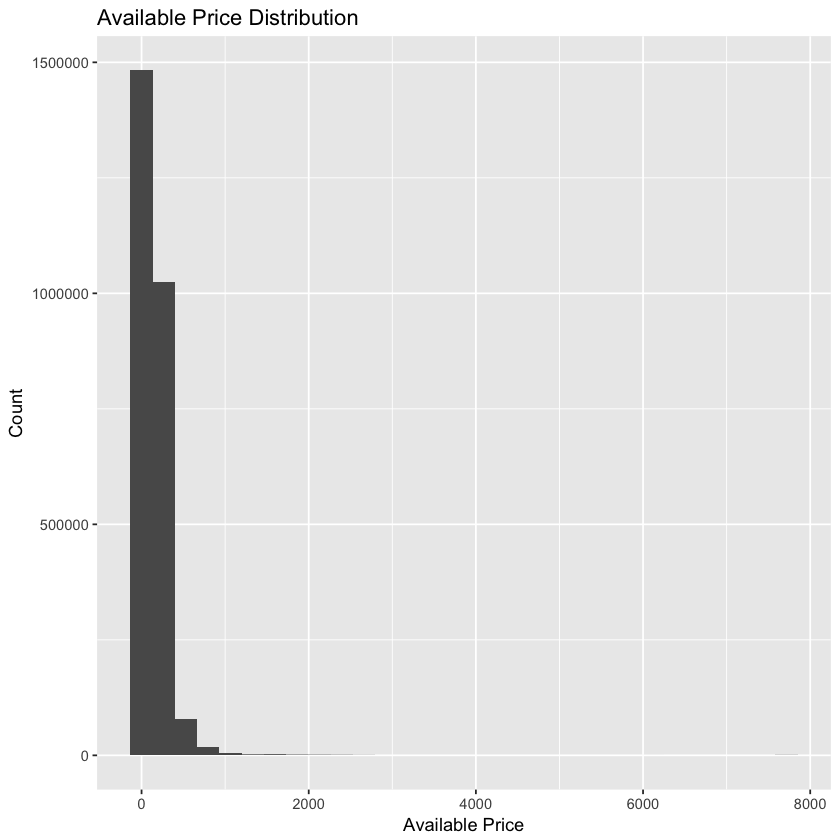

In [142]:
# Let's build some basic visualisations on top of the calendar data set using ggplot2
# A good cheat sheet is available at: https://www.rstudio.com/wp-content/uploads/2015/03/ggplot2-cheatsheet.pdf

# Visualise the price distribution
pl <- ggplot(calendar_data, aes(price)) + geom_histogram() + labs(title = "Available Price Distribution") + 
    labs(x = "Available Price", y = "Count")
pl


In [143]:
# From here we can see there is an obvious outlier
# Let's further investigate the properties of price
quantile(calendar_data$price, seq(0, 1, 0.05), na.rm = TRUE)

0%   5%  10%  15%  20%  25%  30%  35%  40%  45%  50%  55%  60%  65%  70%  75% 
  10   40   50   56   65   71   80   90   99  109  120  130  143  154  170  187 
 80%  85%  90%  95% 100% 
 200  240  281  375 7725

In [97]:
# drilling down on the top 5%
quantile(calendar_data$price, seq(0.95, 1, 0.005), na.rm = TRUE)

95% 95.5%   96% 96.5%   97% 97.5%   98% 98.5%   99% 99.5%  100% 
  375   390   400   427   450   489   500   599   700   900  7725

In [104]:
# R has many neat functions, one of them is ecdf which allows you to input a vector 
# and get a percentile for a specific input
price_points <- c(1000, 2000, 3000, 5000)
print(paste("Available Price point", price_points, "has percentile", round(ecdf(calendar_data$price)(price_points) * 100.0, 3)))

[1] "Price point 1000 has percentile 99.706"
[2] "Price point 2000 has percentile 99.953"
[3] "Price point 3000 has percentile 99.985"
[4] "Price point 5000 has percentile 99.985"


In [105]:
# if you are unsure of what a function does or the input it takes, you can call the help command via ?
?ecdf

5% 95% 
 40 375

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2855631 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1 rows containing missing values (geom_bar).”

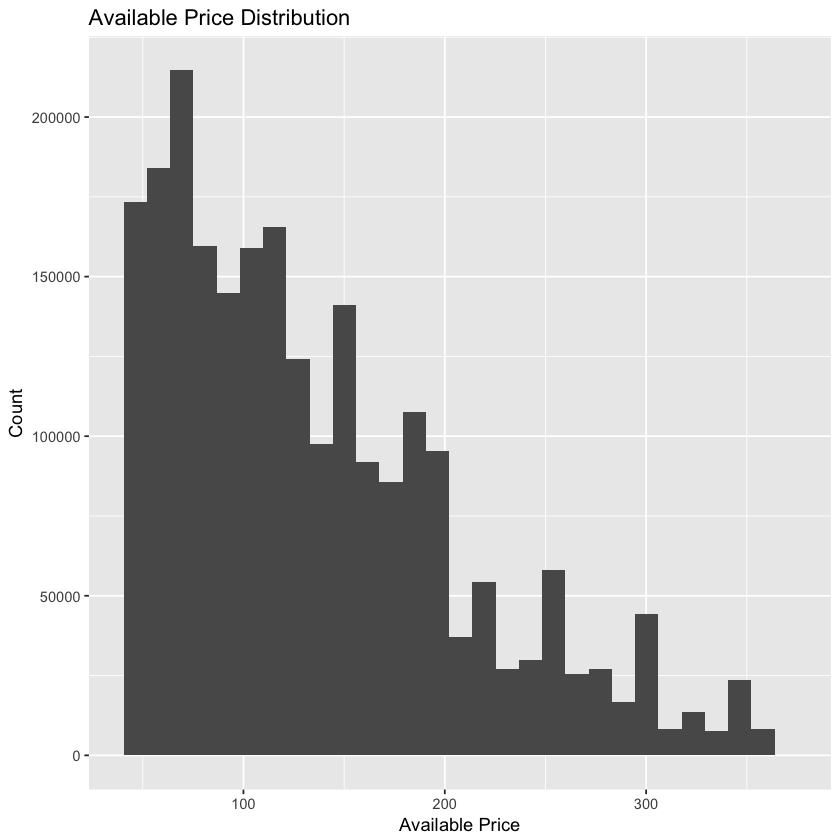

In [144]:
# as an illustration, let's re-plot our histogram with only the 5% to 95% percentile range.
(range <- quantile(calendar_data$price, c(0.05, 0.95), na.rm = TRUE))
pl <- ggplot(calendar_data, aes(price)) + geom_histogram() + labs(title = "Available Price Distribution") + 
    labs(x = "Available Price", y = "Count") + xlim(range)
pl

In [125]:
# Let's build another visualisation to depict price trend over time

# First we need to summarise our data
# A popular and good package for fast computation in R is data.table (replaces base data.frame)
# Refer to: https://s3.amazonaws.com/assets.datacamp.com/img/blog/data+table+cheat+sheet.pdf

# Convert our data.frame to data.table
calendar_data_dt <- data.table(calendar_data)
(class(calendar_data_dt))

[1] "data.table" "data.frame"

In [114]:
# Let's summarise by average price per week
(head(calendar_data_dt$date, n = 20))

[1] "2018-04-02" "2018-04-01" "2018-03-31" "2018-03-30" "2018-03-29"
 [6] "2018-03-28" "2018-03-27" "2018-03-26" "2018-03-25" "2018-03-24"
[11] "2018-03-23" "2018-03-22" "2018-03-21" "2018-03-20" "2018-03-19"
[16] "2018-03-18" "2018-03-17" "2018-03-16" "2018-03-15" "2018-03-14"

In [116]:
# A good package for date handling/manipulation is lubridate
head(round_date(calendar_data_dt$date, unit = "week"), n = 20)

[1] "2018-04-01" "2018-04-01" "2018-04-01" "2018-04-01" "2018-04-01"
 [6] "2018-03-25" "2018-03-25" "2018-03-25" "2018-03-25" "2018-03-25"
[11] "2018-03-25" "2018-03-25" "2018-03-18" "2018-03-18" "2018-03-18"
[16] "2018-03-18" "2018-03-18" "2018-03-18" "2018-03-18" "2018-03-11"

In [127]:
head(calendar_data$date)

[1] "2018-04-02" "2018-04-01" "2018-03-31" "2018-03-30" "2018-03-29"
[6] "2018-03-28"

In [146]:
# Let's add this as a new field in the dataset
# Note that within the data.table, we don't need to address date as an attribute
calendar_data_dt[, week_date := round_date(date, unit = "week")]


In [120]:
head(calendar_data_dt[available != 'f'], n = 20)

listing_id,date,available,price,week_date
17948917,2017-09-30,t,50,2017-10-01
17948917,2017-09-29,t,50,2017-10-01
17948917,2017-09-28,t,50,2017-10-01
17948917,2017-09-27,t,50,2017-09-24
17948917,2017-09-26,t,50,2017-09-24
17948917,2017-09-25,t,50,2017-09-24
17948917,2017-09-24,t,50,2017-09-24
17948917,2017-09-23,t,50,2017-09-24
17948917,2017-09-22,t,50,2017-09-24
17948917,2017-09-21,t,50,2017-09-24


In [122]:
# Let's group it by week_date and take the average price
head(calendar_data_dt[, mean(price, na.rm = TRUE), by = week_date], n = 20)

week_date,V1
2018-04-01,161.4697
2018-03-25,160.5058
2018-03-18,160.3452
2018-03-11,159.7147
2018-03-04,159.0976
2018-02-25,160.4905
2018-02-18,160.9128
2018-02-11,161.2195
2018-02-04,160.9889
2018-01-28,165.2201


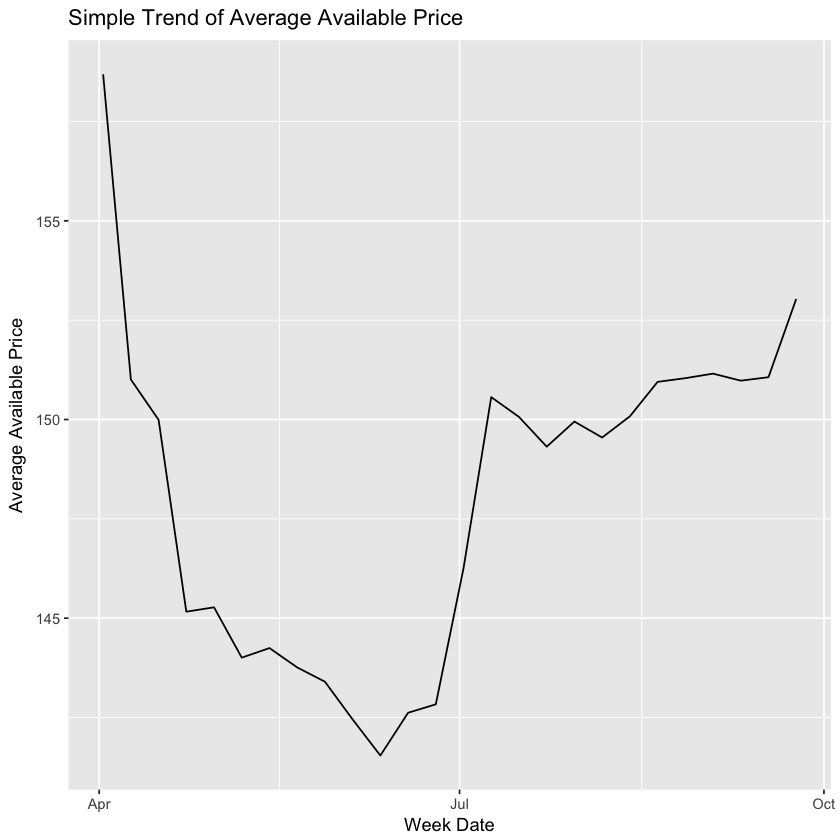

In [152]:
# Visualise the trend
ggplot(calendar_data_dt[week_date < now(), mean(price, na.rm = TRUE), by = week_date], aes(x = week_date, y = V1)) + geom_line() +
    labs(x = "Week Date", y = "Average Available Price", title = "Simple Trend of Average Available Price")

In [153]:
# Useful site to extract occupancy rates/income: http://tomslee.net/airbnb-data-collection-methodology-and-accuracy

# Let's look at the listing summary CSV
listing_summary <- read_csv("listings_summary.csv")

Parsed with column specification:
cols(
  id = col_integer(),
  name = col_character(),
  host_id = col_integer(),
  host_name = col_character(),
  neighbourhood_group = col_character(),
  neighbourhood = col_character(),
  latitude = col_double(),
  longitude = col_double(),
  room_type = col_character(),
  price = col_integer(),
  minimum_nights = col_integer(),
  number_of_reviews = col_integer(),
  last_review = col_date(format = ""),
  reviews_per_month = col_double(),
  calculated_host_listings_count = col_integer(),
  availability_365 = col_integer()
)


In [154]:
# As per usual let's look at some summary statistics
(dim(listing_summary))
(summary(listing_summary))

[1] 14305    16

       id               name              host_id           host_name        
 Min.   :    9835   Length:14305       Min.   :       19   Length:14305      
 1st Qu.: 6906130   Class :character   1st Qu.:  9337376   Class :character  
 Median :11682326   Mode  :character   Median : 27080368   Mode  :character  
 Mean   :11019224                      Mean   : 36768671                     
 3rd Qu.:15773640                      3rd Qu.: 52874277                     
 Max.   :18031980                      Max.   :123954518                     
                                                                             
 neighbourhood_group neighbourhood         latitude        longitude    
 Length:14305        Length:14305       Min.   :-38.22   Min.   :144.5  
 Class :character    Class :character   1st Qu.:-37.86   1st Qu.:145.0  
 Mode  :character    Mode  :character   Median :-37.82   Median :145.0  
                                        Mean   :-37.83   Mean   :145.0  
           

In [155]:
# Let's build a basic linear regression model to see the effects of:
# room_type, number_of_reviews, minimum_nights, Availability_365 has on the set price

price.model <- lm(price ~ minimum_nights + room_type + number_of_reviews + availability_365, data = listing_summary)

In [156]:
summary(price.model)


Call:
lm(formula = price ~ minimum_nights + room_type + number_of_reviews + 
    availability_365, data = listing_summary)

Residuals:
    Min      1Q  Median      3Q     Max 
-1197.1   -50.2   -18.3    14.6  9384.5 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            1.766e+02  2.624e+00  67.287   <2e-16 ***
minimum_nights         1.263e+00  8.992e-02  14.045   <2e-16 ***
room_typePrivate room -1.157e+02  2.813e+00 -41.114   <2e-16 ***
room_typeShared room  -1.464e+02  8.855e+00 -16.530   <2e-16 ***
number_of_reviews     -4.577e-01  5.098e-02  -8.979   <2e-16 ***
availability_365       9.519e-02  9.764e-03   9.749   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 161.9 on 14299 degrees of freedom
Multiple R-squared:  0.1276,	Adjusted R-squared:  0.1273 
F-statistic: 418.2 on 5 and 14299 DF,  p-value: < 2.2e-16


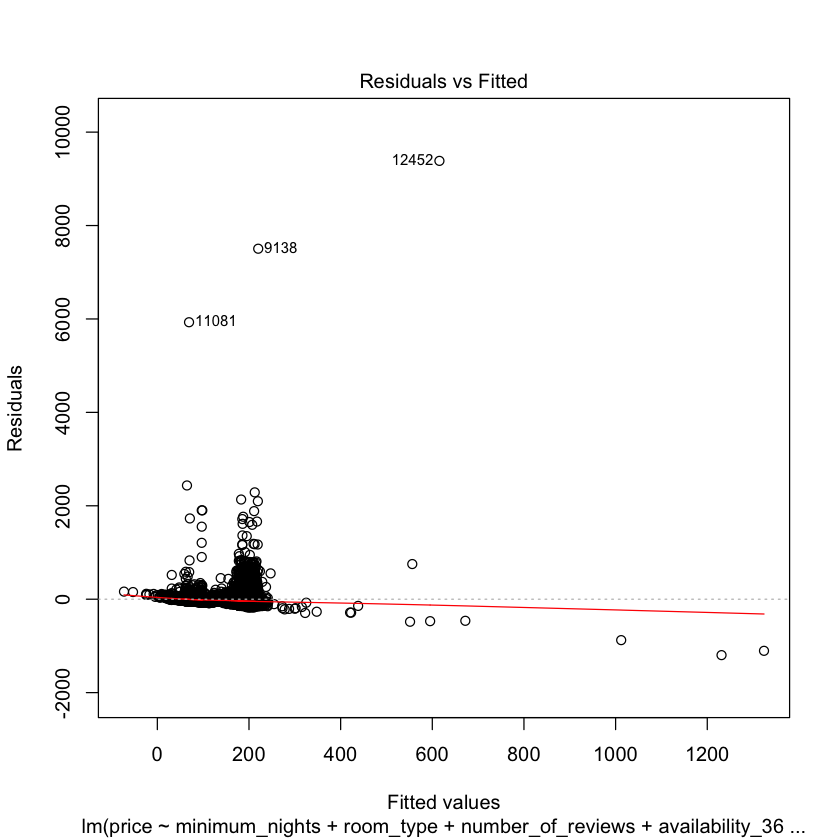

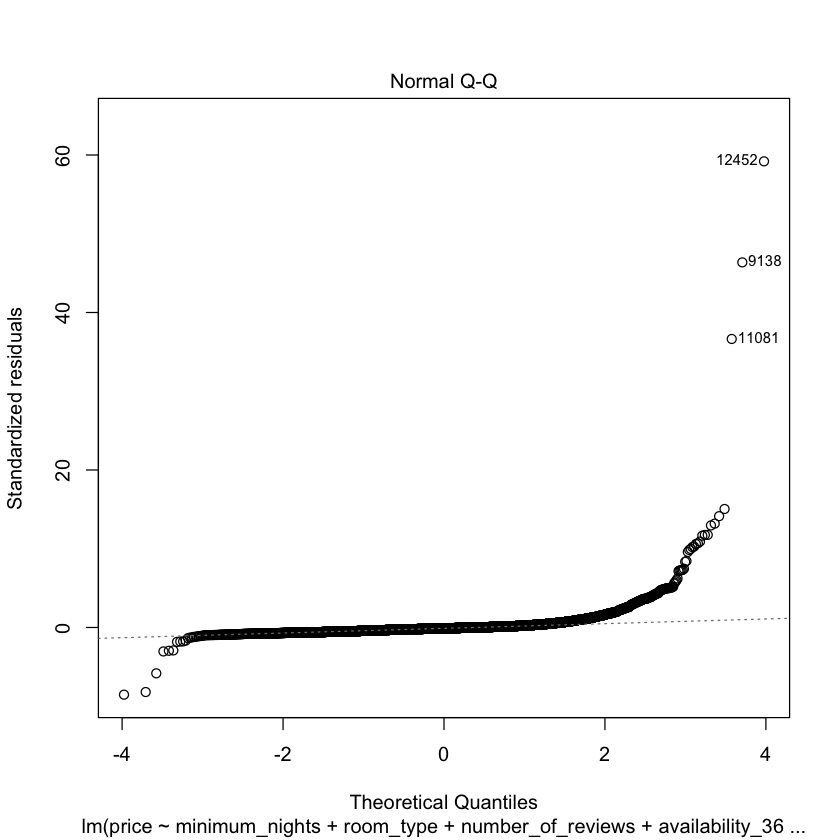

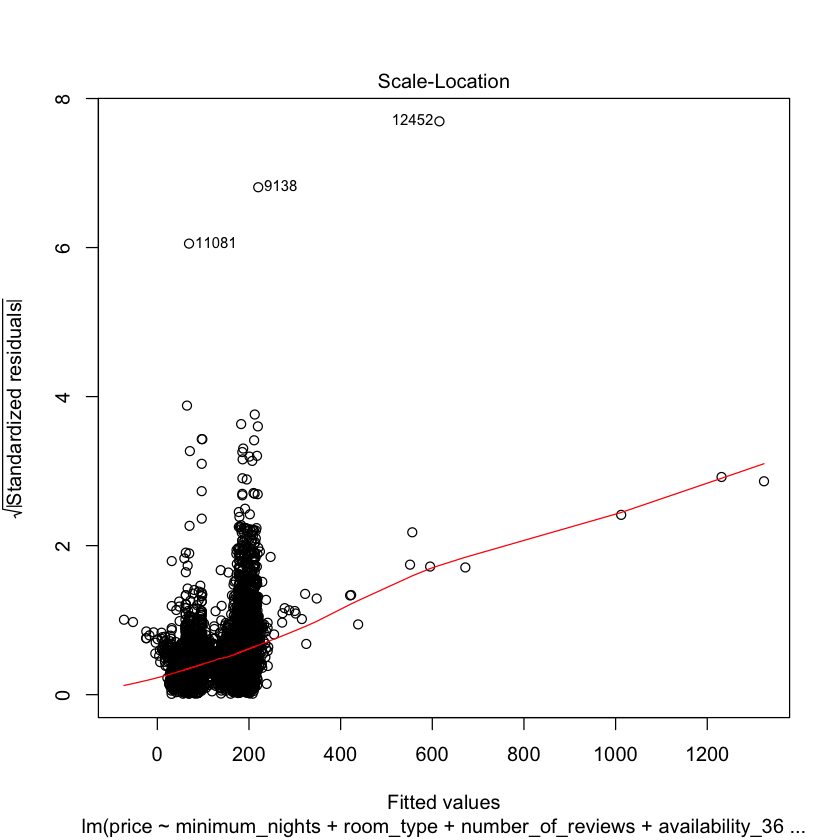

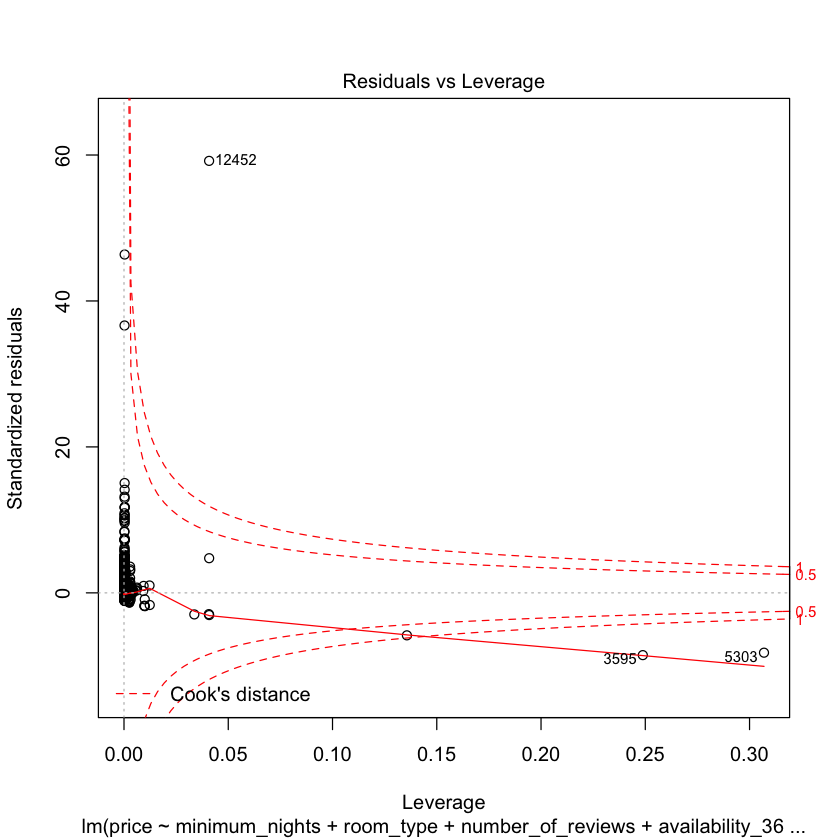

In [159]:
plot(price.model)

In [160]:
# Let's take a look at those points and remove them
listing_summary[c(11081, 9138, 12452),]

id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
17614721,TEST,118797373,Agustin,NA,Melbourne,-37.84723,144.9125,Private room,5999,4,0,NA,NA,1,34
17943667,LUXICO - Hm@s Penthouse,11914644,Luxico Holiday Homes,NA,Port Phillip,-37.84542,144.9414,Entire home/apt,7724,7,0,NA,NA,58,365
4185965,Z - Spectacular Sky View 2BR APARTMENT! (RETIRED),10394006,Daniel,NA,Melbourne,-37.80796,144.9608,Entire home/apt,10000,365,48,2015-12-06,1.67,15,0


In [161]:
listing_summary_removeout <- listing_summary[-c(11081, 9138, 12452),]

In [162]:
price.model_out <- lm(price ~ minimum_nights + room_type + number_of_reviews + availability_365,
                      data = listing_summary_removeout)


In [163]:
summary(price.model_out)
# R^2 still quite low, variance only partially explained (missing variables/predictors - i.e. seasonality as per previous graph in calendar?)


Call:
lm(formula = price ~ minimum_nights + room_type + number_of_reviews + 
    availability_365, data = listing_summary_removeout)

Residuals:
    Min      1Q  Median      3Q     Max 
-206.28  -48.98  -17.66   15.55 2436.94 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            1.778e+02  1.875e+00  94.841   <2e-16 ***
minimum_nights         1.588e-01  6.560e-02   2.422   0.0155 *  
room_typePrivate room -1.153e+02  2.010e+00 -57.334   <2e-16 ***
room_typeShared room  -1.460e+02  6.328e+00 -23.069   <2e-16 ***
number_of_reviews     -4.856e-01  3.644e-02 -13.328   <2e-16 ***
availability_365       9.840e-02  6.978e-03  14.102   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 115.7 on 14296 degrees of freedom
Multiple R-squared:  0.2041,	Adjusted R-squared:  0.2038 
F-statistic: 733.3 on 5 and 14296 DF,  p-value: < 2.2e-16


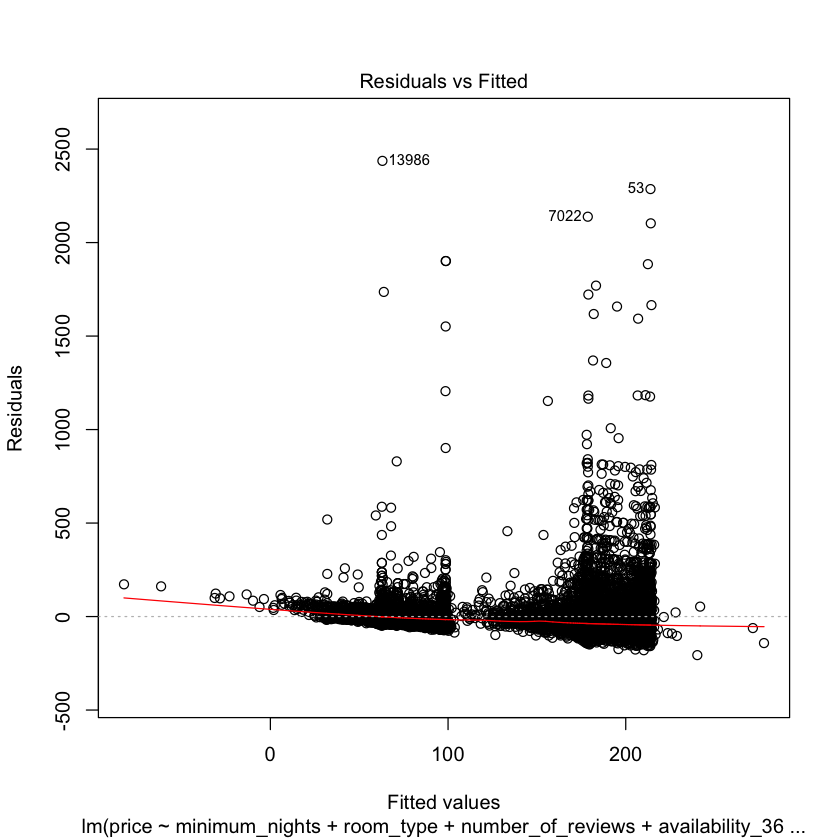

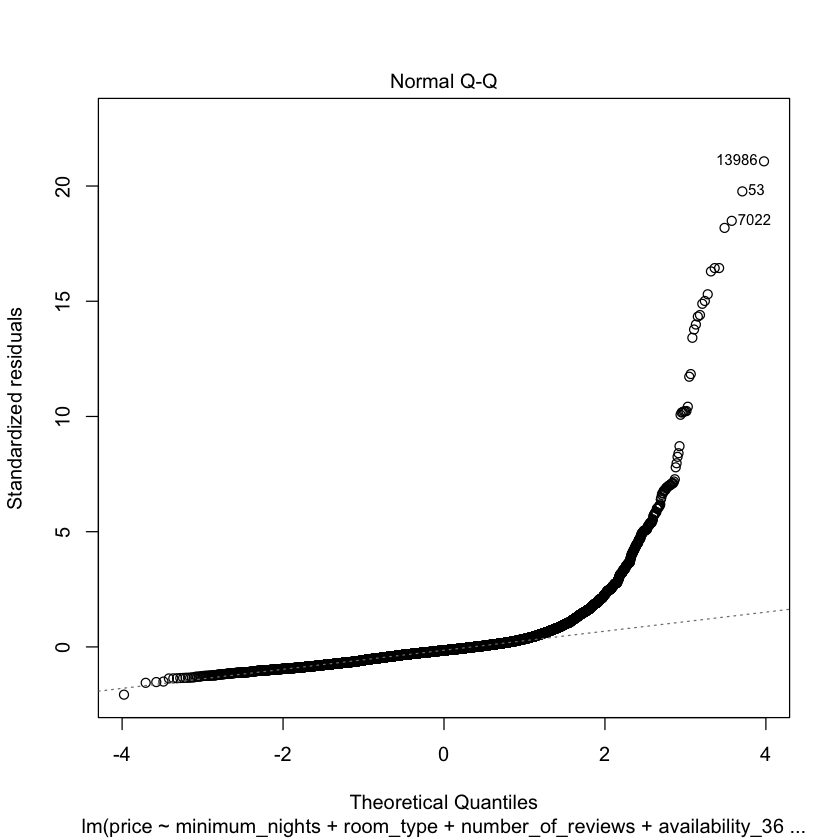

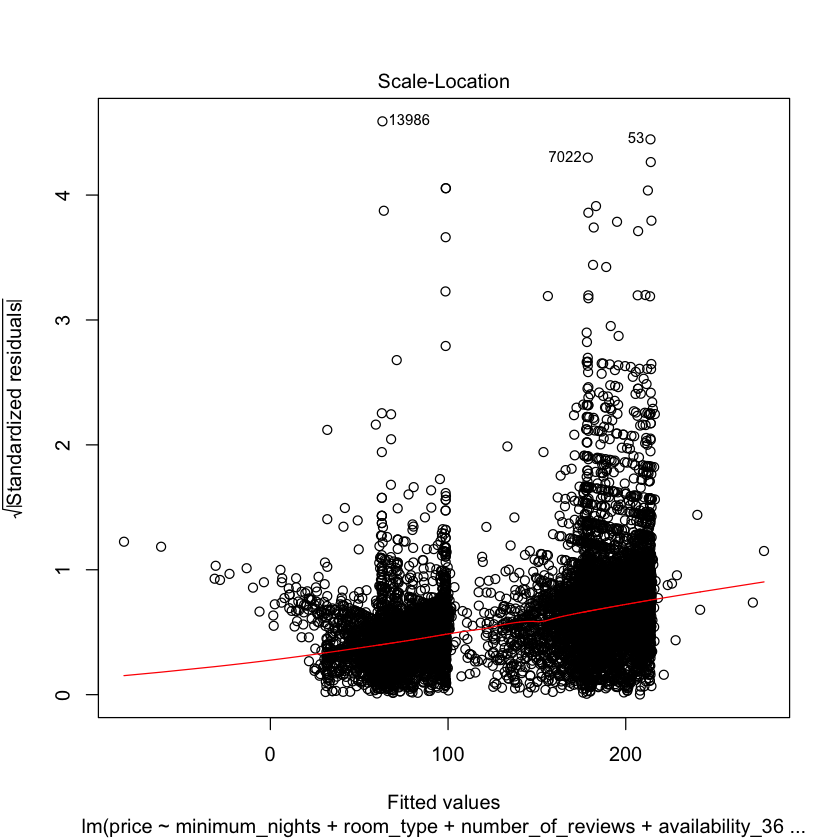

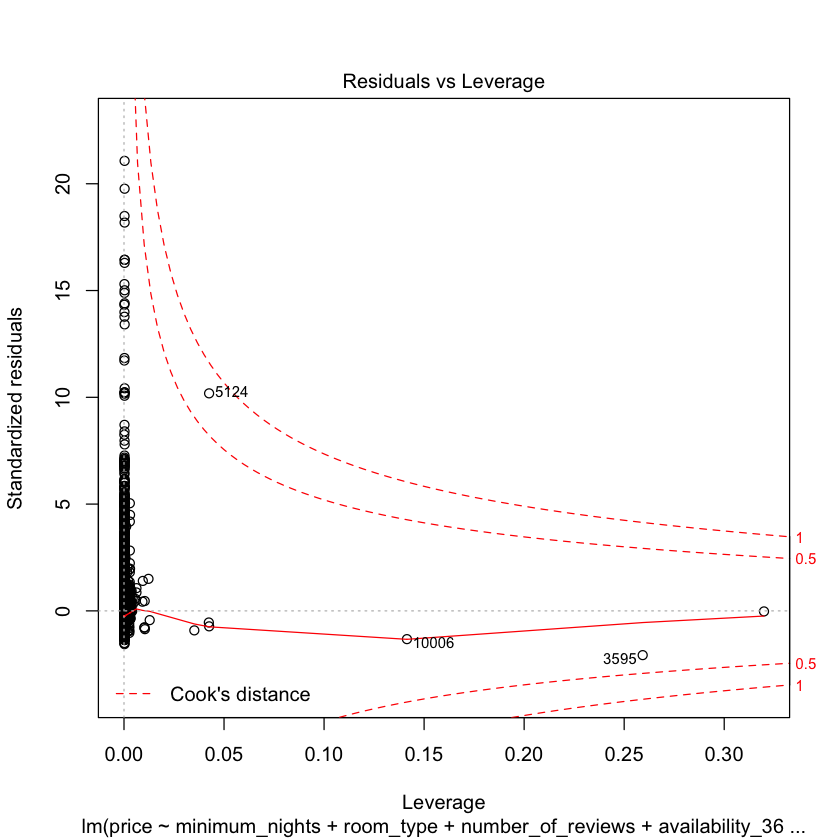

In [164]:
plot(price.model_out) 
# still some work to do! q-q plot still pretty poor - means that it has more extreme values
# than as per assumed from a normal distribution 